✅ このパイプラインでできること

CSVのsignal_indexに対応するnpyデータのみ抽出

SBPと患者IDを同期

5mmHgごとのsbp_binラベル付与

sbp_binごとに患者IDを考慮したダウンサンプリング（各ビンのサンプル数を均一化）

波形（BP/PPG）とラベルを揃えて保存

In [9]:
import numpy as np
import pandas as pd

# ---------------------------
# データ抽出 + ビン付け
# ---------------------------
def prepare_with_bins(
    wave_npy_path,
    sbp_npy_path,
    subject_npy_path,
    feature_csv_path
):
    """
    CSV の signal_index に基づき npy からデータを抽出。
    sbp, subject を同期して取得。
    5mmHgビン sbp_bin も付与。
    """
    waves = np.load(wave_npy_path).squeeze()  # (N, 2, 1250) or (N, 1250)         
    sbp_all = np.load(sbp_npy_path)        
    subjects_all = np.load(subject_npy_path) 
    df = pd.read_csv(feature_csv_path)      
    print(f"Loaded npy: {waves.shape}, csv: {df.shape}",waves.ndim)
    idx = df["signal_index"].values

    sbp = sbp_all[idx]
    subject = subjects_all[idx]
    if waves.ndim != 2:
        waves = waves[idx, 1, :]        # (N, 1, 1250)
    sbp_bin = (sbp // 5).astype(int)
    df["sbp_bin"] = sbp_bin
    # df["subject_id"] = subject
    return df, waves


# ---------------------------
# ビンごとに患者IDを考慮してダウンサンプリング
# ---------------------------
def stratified_downsample(df, ppg_wave, random_state=42):
    """
    sbp_binごとに、患者IDを混ぜた状態でサンプル数を揃える。
    """
    # ビンごとの最小サンプル数
    min_count = df.groupby("sbp_bin").size().min()
    print(df.groupby("sbp_bin").size())
    sampled_idx = []
    for b, group in df.groupby("sbp_bin"):
        sampled = group.sample(n=min_count, replace=False, random_state=random_state)
        sampled_idx.append(sampled.index.values)

    sampled_idx = np.concatenate(sampled_idx)

    return df.iloc[sampled_idx].reset_index(drop=True), ppg_wave[sampled_idx]




In [10]:
def merge_extreme_bins(df, ratio_threshold=0.01, verbose=True):
    """
    sbp_binごとに、両端の極端なビンを1つにまとめる
    ratio_threshold: 全体に対する累積比率でまとめる範囲を決める
    """
    # sbp_binごとの件数
    counts = df['sbp_bin'].value_counts().sort_index()  # 小さい順
    if verbose: 
        print("Before merging extreme bins:")
        print(counts)
    total = counts.sum()
    if verbose:
        print(f"Total samples: {total}")    
    # 左端（低血圧側）
    cum_left = counts.cumsum() / total
    left_bins_to_merge = cum_left[cum_left <= ratio_threshold].index
    if verbose:
        print(cum_left)
    # 右端（高血圧側）
    cum_right = counts[::-1].cumsum() / total
    right_bins_to_merge = cum_right[cum_right <= ratio_threshold].index
    if verbose:
        print(cum_right)
    # 新しい sbp_bin 列
    df = df.copy()
    if len(left_bins_to_merge) > 0:
        min_bin = left_bins_to_merge.max()
        df.loc[df['sbp_bin'].isin(left_bins_to_merge), 'sbp_bin'] = min_bin

    if len(right_bins_to_merge) > 0:
        max_bin = right_bins_to_merge.min()
        df.loc[df['sbp_bin'].isin(right_bins_to_merge), 'sbp_bin'] = max_bin

    return df,max(left_bins_to_merge) if len(left_bins_to_merge) > 0 else None,min(right_bins_to_merge) if len(right_bins_to_merge) > 0 else None

In [11]:

def extract_data_by_csv(npy_path, csv_path):
    """
    npy と csv を読み込み、csv の signal_index に対応するデータだけ抜き出す。
    
    return:
        df: csv（特徴量 + sbp + sbp_bin 追加）
        bp_wave: shape = (M, 1250)
        ppg_wave: shape = (M, 1250)
    """
    # ---- load files ----
    data = np.load(npy_path).squeeze()               # (N, 2, 1250)
    df = pd.read_csv(csv_path)             # 包含 signal_index, subject, features...
    print(f"Loaded npy: {data.shape}, csv: {df.shape}")
    # signal_index を取得
    idx = df["signal_index"].values

    # ---- extract npy rows ----
    if data.ndim != 2:
        data = data[:, 1, :]      # (N, 1, 1250)

    # ---- derive SBP representative (max recommended for waveform SBP) ----
    sbp = df["sbp"]             # 必要なら max に変更可
    sbp_bin = (sbp // 5).astype(int)       # 5 mmHg bin

    # ---- append to dataframe ----
    df["sbp_bin"] = sbp_bin
    
    return df,data


In [12]:
def stratified_downsample_per_subject(df, ppg_wave, random_state=42):
    """
    sbp_binごとに、各患者(subject)のサンプル数をなるべく均等に揃えてダウンサンプリングする
    """
    sampled_idx = []

    for b, bin_group in df.groupby("sbp_bin"):
        # このビン内の各患者ごとのサンプル数
        patient_counts = bin_group["subject"].value_counts()
        min_per_patient = patient_counts.min()  # このビン内で患者ごとの最小サンプル数

        for patient, patient_group in bin_group.groupby("subject"):
            # 最小サンプル数までダウンサンプリング
            n_samples = min(min_per_patient, len(patient_group))
            sampled = patient_group.sample(n=n_samples, replace=False, random_state=random_state)
            sampled_idx.append(sampled.index.values)

    sampled_idx = np.concatenate(sampled_idx)

    return df.iloc[sampled_idx].reset_index(drop=True),  ppg_wave[sampled_idx]


In [13]:


def stratified_downsample_max_ratio(df, ppg_wave, max_ratio=0.04, random_state=42):
    """
    sbp_binごとに、subjectごとのサンプル数を均等に保ちながら、
    各ビンを全体サンプル数の max_ratio までダウンサンプリングする。
    """
    df = df.copy()
    total_samples = len(df)
    max_samples_per_bin = int(total_samples * max_ratio)
    
    sampled_idx = []

    for b, bin_group in df.groupby("sbp_bin"):
        # このビンのサンプル数
        n_samples_bin = len(bin_group)

        if n_samples_bin <= max_samples_per_bin:
            # ビンのサンプルが少なければそのまま
            sampled_idx.append(bin_group.index.values)
            continue

        # subjectごとのグループ
        subjects = bin_group['subject'].unique()
        n_subjects = len(subjects)
        
        # 各subjectに割り当てるサンプル数
        n_per_subject = max_samples_per_bin // n_subjects
        
        # 各subjectから n_per_subject サンプル抽出
        bin_sampled_idx = []
        for sub in subjects:
            sub_group = bin_group[bin_group['subject'] == sub]
            n_sub = min(len(sub_group), n_per_subject)
            sampled = sub_group.sample(n=n_sub, replace=False, random_state=random_state)
            bin_sampled_idx.append(sampled.index.values)

        sampled_idx.append(np.concatenate(bin_sampled_idx))

    # 結合
    sampled_idx = np.concatenate(sampled_idx)

    return df.iloc[sampled_idx].reset_index(drop=True), ppg_wave[sampled_idx]


In [14]:
def stratified_downsample_max_ratio(df, ppg_wave, max_ratio=0.04, random_state=42):
    """
    sbp_binごとに、subjectごとのサンプル数を均等に保ちながら、
    各ビンを全体サンプル数の max_ratio までダウンサンプリングする。
    残りの枠はサンプルが多いsubjectに再分配。
    """
    df = df.copy()
    total_samples = len(df)
    max_samples_per_bin = int(total_samples * max_ratio)
    
    sampled_idx = []

    for b, bin_group in df.groupby("sbp_bin"):
        n_samples_bin = len(bin_group)

        if n_samples_bin <= max_samples_per_bin:
            sampled_idx.append(bin_group.index.values)
            continue

        subjects = bin_group['subject'].unique()
        n_subjects = len(subjects)
        
        # 各subjectの抽出可能な最大数
        sub_counts = bin_group['subject'].value_counts()
        n_per_subject = max_samples_per_bin // n_subjects
        remaining = max_samples_per_bin

        bin_sampled_idx = []

        # 最初に min(n_per_subject, sub_count) を割り当て
        for sub in subjects:
            sub_group = bin_group[bin_group['subject'] == sub]
            n_sub = min(len(sub_group), n_per_subject, remaining)
            sampled = sub_group.sample(n=n_sub, replace=False, random_state=random_state)
            bin_sampled_idx.append(sampled.index.values)
            remaining -= n_sub

        # 残りの枠を再分配（サンプルが残っているsubjectからランダムに）
        if remaining > 0:
            leftovers = bin_group.drop(np.concatenate(bin_sampled_idx))
            if len(leftovers) > 0:
                extra_sampled = leftovers.sample(n=min(len(leftovers), remaining), random_state=random_state)
                bin_sampled_idx.append(extra_sampled.index.values)

        sampled_idx.append(np.concatenate(bin_sampled_idx))

    sampled_idx = np.concatenate(sampled_idx)
    return df.iloc[sampled_idx].reset_index(drop=True), ppg_wave[sampled_idx]


In [15]:
def merge_extreme_bins_test(df_test, left_merge_value, right_merge_value):
    """
    train の基準値を使って test データの両端ビンをまとめる
    """
    df_merged = df_test.copy()

    if left_merge_value is not None:
        df_merged.loc[df_merged['sbp_bin'] <= left_merge_value, 'sbp_bin'] = left_merge_value
    if right_merge_value is not None:
        df_merged.loc[df_merged['sbp_bin'] >= right_merge_value, 'sbp_bin'] = right_merge_value

    return df_merged


### run

In [16]:

# ---------------------------
# パイプライン実行例
# ---------------------------

# train
train_df, train_ppg_wave = prepare_with_bins(
    wave_npy_path=r"F:\minowa\BloodPressureEstimation\data\processed\BP_npy\PulseDB\train_4.npy",
    sbp_npy_path=r"F:\minowa\BloodPressureEstimation\data\processed\BP_npy\PulseDB\train_sbp.npy",
    subject_npy_path=r"F:\minowa\BloodPressureEstimation\data\processed\BP_npy\PulseDB\train_subjects.npy",
    feature_csv_path=r"F:\minowa\BloodPressureEstimation\data\results\ppg_features_pulsedb_train3_all.csv"
)
train_df_merged,left,right = merge_extreme_bins(train_df, ratio_threshold=0.002, verbose=False)
print("Merged left bins:", left, "right bins:", right)
train_df_bal, train_ppg_bal = stratified_downsample_max_ratio(train_df_merged, train_ppg_wave, max_ratio=0.04)

# test
test_df, test_ppg_wave = prepare_with_bins(
wave_npy_path=r"F:\minowa\BloodPressureEstimation\data\processed\BP_npy\PulseDB\test_4.npy",
    sbp_npy_path=r"F:\minowa\BloodPressureEstimation\data\processed\BP_npy\PulseDB\test_sbp.npy",
    subject_npy_path=r"F:\minowa\BloodPressureEstimation\data\processed\BP_npy\PulseDB\test_subjects.npy",
    feature_csv_path=r"F:\minowa\BloodPressureEstimation\data\results\ppg_features_pulsedb_test3_all.csv"

)
test_df_merged = merge_extreme_bins_test(test_df, left, right)
test_df_bal, test_ppg_bal = stratified_downsample_max_ratio(test_df_merged, test_ppg_wave, max_ratio=0.04)


# ---------------------------
# 保存例
# ---------------------------
# train_df_bal.to_csv("train_labels_bal.csv", index=False)
# np.save("train_ppg_bal.npy", train_ppg_bal)

# test_df_bal.to_csv("test_labels_bal.csv", index=False)
# np.save("test_ppg_bal.npy", test_ppg_bal)
print("train", train_df_bal.shape, train_ppg_bal.shape)
print("test", test_df_bal.shape, test_ppg_bal.shape)

Loaded npy: (902160, 1250), csv: (835927, 103) 2
Merged left bins: 12 right bins: 39
Loaded npy: (111600, 1250), csv: (102896, 103) 2
train (513924, 104) (513924, 1250)
test (62971, 104) (62971, 1250)


In [55]:
test_df = pd.read_csv("../data/results/ppg_features_pulsedb_test3_all.csv")
print(test_df.columns.tolist() )

['Unnamed: 0', 'Tc', 'Ts', 'Td', 'Tsteepest', 'Steepest', 'TNegSteepest', 'NegSteepest', 'TdiaRise', 'DiaRise', 'SteepDiaRise', 'TSystoDiaRise', 'TdiaToEnd', 'Ratio', 'Ts_norm', 'Td_norm', 'Tsteepest_norm', 'TNegSteepest_norm', 'TdiaRise_norm', 'TSystoDiaRise_norm', 'TdiaToEnd_norm', 'SW25', 'SW25_norm', 'DW25', 'DW25_norm', 'SWaddDW25', 'SWaddDW25_norm', 'DWdivSW25', 'SW50', 'SW50_norm', 'DW50', 'DW50_norm', 'SWaddDW50', 'SWaddDW50_norm', 'DWdivSW50', 'SW75', 'SW75_norm', 'DW75', 'DW75_norm', 'SWaddDW75', 'SWaddDW75_norm', 'DWdivSW75', 'S1', 'S2', 'S3', 'S4', 'AUCsys', 'AUCdia', 'S1_norm', 'S2_norm', 'S3_norm', 'S4_norm', 'AUCsys_norm', 'AUCdia_norm', 'SQI_skew', 'SQI_kurtosis', 'apg_a', 'apg_b', 'apg_c', 'apg_d', 'apg_e', 'ppg_a', 'ppg_b', 'ppg_c', 'ppg_d', 'ppg_e', 'ratio_apg_b', 'ratio_apg_c', 'ratio_apg_d', 'ratio_apg_e', 'ratio_ppg_b', 'ratio_ppg_c', 'ratio_ppg_d', 'ratio_ppg_e', 'T_a', 'T_b', 'T_c', 'T_d', 'T_e', 'T_a_norm', 'T_b_norm', 'T_c_norm', 'T_d_norm', 'T_e_norm', 'T_pea

In [56]:
test_df2 = pd.read_csv("../data/results/ppg_features_pulsedb_test_all.csv")
print(test_df2.columns.tolist() )
# print column diffs 
print( set(test_df2.columns.tolist()) -set(test_df.columns.tolist()))

['Unnamed: 0', 'Tc', 'Ts', 'Td', 'Tsteepest', 'Steepest', 'TNegSteepest', 'NegSteepest', 'TdiaRise', 'DiaRise', 'SteepDiaRise', 'TSystoDiaRise', 'TdiaToEnd', 'Ratio', 'Ts_norm', 'Td_norm', 'Tsteepest_norm', 'TNegSteepest_norm', 'TdiaRise_norm', 'TSystoDiaRise_norm', 'TdiaToEnd_norm', 'SW25', 'SW25_norm', 'DW25', 'DW25_norm', 'SWaddDW25', 'SWaddDW25_norm', 'DWdivSW25', 'SW50', 'SW50_norm', 'DW50', 'DW50_norm', 'SWaddDW50', 'SWaddDW50_norm', 'DWdivSW50', 'SW75', 'SW75_norm', 'DW75', 'DW75_norm', 'SWaddDW75', 'SWaddDW75_norm', 'DWdivSW75', 'S1', 'S2', 'S3', 'S4', 'AUCsys', 'AUCdia', 'S1_norm', 'S2_norm', 'S3_norm', 'S4_norm', 'AUCsys_norm', 'AUCdia_norm', 'SQI_skew', 'SQI_kurtosis', 'apg_a', 'apg_b', 'apg_c', 'apg_d', 'apg_e', 'ppg_a', 'ppg_b', 'ppg_c', 'ppg_d', 'ppg_e', 'ratio_apg_b', 'ratio_apg_c', 'ratio_apg_d', 'ratio_apg_e', 'ratio_ppg_b', 'ratio_ppg_c', 'ratio_ppg_d', 'ratio_ppg_e', 'T_a', 'T_b', 'T_c', 'T_d', 'T_e', 'T_a_norm', 'T_b_norm', 'T_c_norm', 'T_d_norm', 'T_e_norm', 'T_pea

In [54]:
train_df = pd.read_csv("../data/results/ppg_features_pulsedb_train2_all.csv")
print(train_df.shape)
print(train_df.columns.tolist() )

(846791, 93)
['Unnamed: 0', 'Tc', 'Ts', 'Td', 'Tsteepest', 'Steepest', 'TNegSteepest', 'NegSteepest', 'TdiaRise', 'DiaRise', 'SteepDiaRise', 'TSystoDiaRise', 'TdiaToEnd', 'Ratio', 'Ts_norm', 'Td_norm', 'Tsteepest_norm', 'TNegSteepest_norm', 'TdiaRise_norm', 'TSystoDiaRise_norm', 'TdiaToEnd_norm', 'SW25', 'SW25_norm', 'DW25', 'DW25_norm', 'SWaddDW25', 'SWaddDW25_norm', 'DWdivSW25', 'SW50', 'SW50_norm', 'DW50', 'DW50_norm', 'SWaddDW50', 'SWaddDW50_norm', 'DWdivSW50', 'SW75', 'SW75_norm', 'DW75', 'DW75_norm', 'SWaddDW75', 'SWaddDW75_norm', 'DWdivSW75', 'S1', 'S2', 'S3', 'S4', 'AUCsys', 'AUCdia', 'S1_norm', 'S2_norm', 'S3_norm', 'S4_norm', 'AUCsys_norm', 'AUCdia_norm', 'SQI_skew', 'SQI_kurtosis', 'apg_a', 'apg_b', 'apg_c', 'apg_d', 'apg_e', 'ppg_a', 'ppg_b', 'ppg_c', 'ppg_d', 'ppg_e', 'ratio_apg_b', 'ratio_apg_c', 'ratio_apg_d', 'ratio_apg_e', 'ratio_ppg_b', 'ratio_ppg_c', 'ratio_ppg_d', 'ratio_ppg_e', 'T_a', 'T_b', 'T_c', 'T_d', 'T_e', 'T_a_norm', 'T_b_norm', 'T_c_norm', 'T_d_norm', 'T_e_

In [57]:
train_df.shape, test_df.shape, test_df2.shape

((846791, 93), (104928, 103), (90289, 103))

In [43]:
set(test_df.columns.tolist()) - set(train_df.columns.tolist())

set()

In [37]:
test_df.shape, test_df2.shape

((103364, 93), (90289, 103))

In [10]:
train_df_bal.groupby("sbp_bin").size()

sbp_bin
12      979
13     1132
14     2950
15     6752
16    13919
17    27205
18    34053
19    34053
20    34053
21    34053
22    34053
23    34053
24    34053
25    34053
26    34053
27    34053
28    34053
29    28218
30    21223
31    15299
32    11333
33     7436
34     4971
35     2944
36     1841
37     1083
38      662
39     1211
dtype: int64

33437.08
[ 10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85  90  95
 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185
 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265 270 275
 280 285]


Text(0.5, 23.52222222222222, 'SBP (mmHg)')

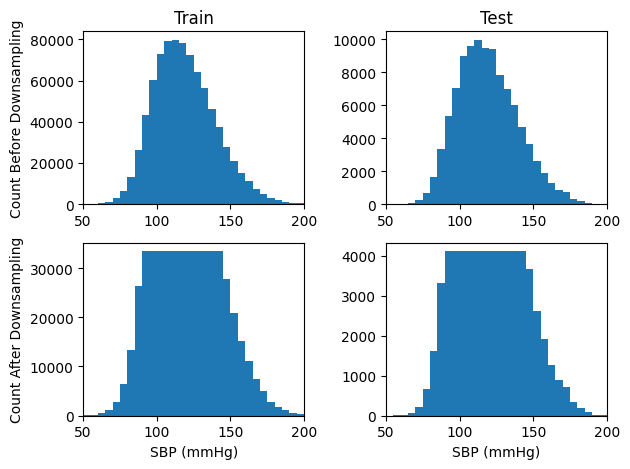

In [17]:
import matplotlib.pyplot as plt; 
plt.subplot(221)
plt.hist(train_df['sbp'],bins=np.arange(train_df['sbp_bin'].min()*5, train_df['sbp_bin'].max()*5+5,5))
plt.xlim(50,200)
plt.title("Train")
plt.ylabel("Count Before Downsampling")
plt.subplot(223)
plt.xlabel("SBP (mmHg)")
plt.ylabel("Count After Downsampling")
plt.hist(train_df_bal['sbp'],bins=np.arange(train_df['sbp_bin'].min()*5, train_df['sbp_bin'].max()*5+5,5))
plt.xlim(50,200)
plt.subplot(222)
plt.hist(test_df['sbp'],bins=np.arange(test_df['sbp_bin'].min()*5, test_df['sbp_bin'].max()*5+5,5))
plt.title("Test")
plt.xlim(50,200)
plt.subplot(224)
plt.hist(test_df_bal['sbp'],bins=np.arange(test_df['sbp_bin'].min()*5, test_df['sbp_bin'].max()*5+5,5))
plt.xlim(50,200)
# plt.subplot(212)
print(len(train_df)*0.04)
print(np.arange(train_df['sbp_bin'].min()*5, train_df['sbp_bin'].max()*5+5,5))
plt.tight_layout()
plt.xlabel("SBP (mmHg)")

In [ ]:
import pandas as pd
test_df = pd.read_parquet(r'F:\minowa\BloodPressureEstimation\data\processed\PulseDB\ppg_features_pulsedb_test3_all.parquet' ).drop('Unnamed: 0', axis=1, errors='ignore')  
train_df = pd.read_csv(r'F:\minowa\BloodPressureEstimation\data\results\ppg_features_pulsedb_train3_all.csv')


In [34]:
dbp = train_df_bal["dbp"]             # 必要なら max に変更可
dbp_bin = (dbp // 5).astype(int)
train_df_bal["dbp_bin"] = dbp_bin
dbp = test_df_bal["dbp"]             # 必要なら max に変更可
dbp_bin = (dbp // 5).astype(int)
test_df_bal["dbp_bin"] = dbp_bin

33437.08
[ 10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85  90  95
 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185
 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265 270 275
 280 285]


Text(0.5, 23.52222222222222, 'DBP (mmHg)')

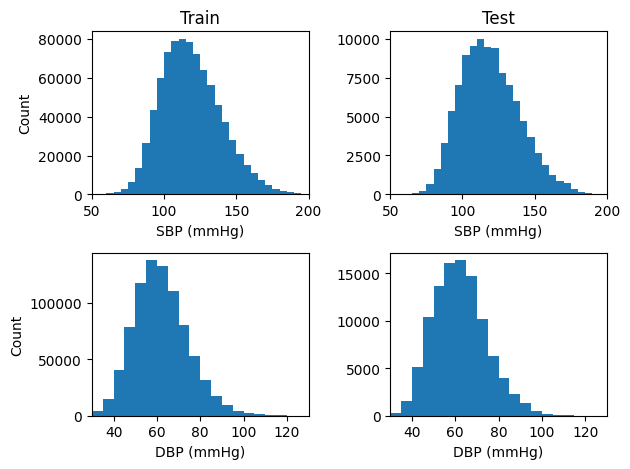

In [33]:
import numpy as np
import matplotlib.pyplot as plt; 
plt.subplot(221)
plt.hist(train_df['sbp'],bins=np.arange(train_df['sbp_bin'].min()*5, train_df['sbp_bin'].max()*5+5,5))
plt.xlim(50,200)
plt.title("Train")
plt.ylabel("Count")
plt.xlabel("SBP (mmHg)")
plt.subplot(223)
plt.xlabel("DBP (mmHg)")
plt.ylabel("Count")
plt.hist(train_df['dbp'],bins=np.arange(train_df['dbp_bin'].min()*5, train_df['dbp_bin'].max()*5+5,5))
plt.xlim(30,130)
plt.subplot(222)
plt.hist(test_df['sbp'],bins=np.arange(test_df['sbp_bin'].min()*5, test_df['sbp_bin'].max()*5+5,5))
plt.title("Test")
plt.xlim(50,200)
plt.xlabel("SBP (mmHg)")
plt.subplot(224)
plt.hist(test_df['dbp'],bins=np.arange(test_df['dbp_bin'].min()*5, test_df['dbp_bin'].max()*5+5,5))
plt.xlim(30,130)
# plt.subplot(212)
print(len(train_df)*0.04)
print(np.arange(train_df['sbp_bin'].min()*5, train_df['sbp_bin'].max()*5+5,5))
plt.tight_layout()
plt.xlabel("DBP (mmHg)")

33437.08
[ 10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85  90  95
 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185
 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265 270 275
 280 285]


Text(0.5, 23.52222222222222, 'DBP (mmHg)')

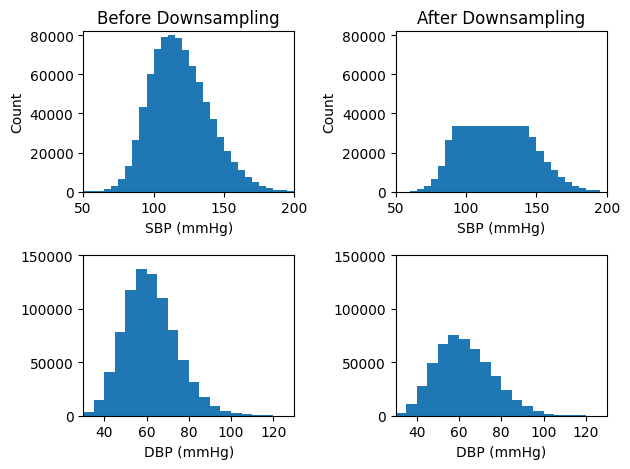

In [48]:
import numpy as np
import matplotlib.pyplot as plt; 
plt.subplot(221)
plt.hist(train_df['sbp'],bins=np.arange(train_df['sbp_bin'].min()*5, train_df['sbp_bin'].max()*5+5,5))
plt.xlim(50,200)
plt.title("Before Downsampling")
plt.ylabel("Count")
plt.xlabel("SBP (mmHg)")
plt.ylim(0,82000)
plt.subplot(222)
plt.title("After Downsampling")
plt.ylim(0,82000)

plt.hist(train_df_bal['sbp'],bins=np.arange(train_df_bal['sbp_bin'].min()*5, train_df_bal['sbp_bin'].max()*5+5,5))
plt.xlabel("SBP (mmHg)")
plt.ylabel("Count")
plt.xlim(50,200)
plt.subplot(223)
plt.ylim(0,150000)
plt.xlabel("DBP (mmHg)")
plt.hist(train_df['dbp'],bins=np.arange(train_df['dbp_bin'].min()*5, train_df['dbp_bin'].max()*5+5,5))
plt.xlim(30,130)
plt.subplot(224)
plt.hist(train_df_bal['dbp'],bins=np.arange(train_df_bal['dbp_bin'].min()*5, train_df_bal['dbp_bin'].max()*5+5,5))
plt.xlim(30,130)
# plt.subplot(212)
plt.ylim(0,150000)
print(len(train_df)*0.04)
print(np.arange(train_df['sbp_bin'].min()*5, train_df['sbp_bin'].max()*5+5,5))
plt.tight_layout()
plt.xlabel("DBP (mmHg)")

In [37]:
train_df.shape

(730808, 105)

In [12]:
train_df_merged = merge_extreme_bins(train_df, ratio_threshold=0.002)
print(train_df_merged['sbp_bin'].value_counts().sort_index())

Before merging extreme bins:
sbp_bin
4         7
5        18
6        64
7        30
8        30
9        52
10      114
11      204
12      460
13     1132
14     2950
15     6752
16    13919
17    27205
18    44410
19    61611
20    74512
21    80676
22    81399
23    79550
24    73043
25    64892
26    57231
27    46872
28    37986
29    28218
30    21223
31    15299
32    11333
33     7436
34     4971
35     2944
36     1841
37     1083
38      662
39      459
40      292
41      229
42       99
43       48
44       45
45       17
46        9
47        5
48        1
49        2
50        2
51        2
57        1
Name: count, dtype: int64
Total samples: 851340
sbp_bin
4     0.000008
5     0.000029
6     0.000105
7     0.000140
8     0.000175
9     0.000236
10    0.000370
11    0.000610
12    0.001150
13    0.002480
14    0.005945
15    0.013876
16    0.030225
17    0.062181
18    0.114346
19    0.186715
20    0.274238
21    0.369002
22    0.464615
23    0.558056
24    0.643853
25  

TypeError: tuple indices must be integers or slices, not str

### test

In [10]:
# ダウンサンプリング実行
# df_bal, bp_bal, ppg_bal = stratified_downsample_per_subject(train_df, train_bp_wave, train_ppg_wave)

# sbp_binごと、subjectごとのサンプル数を集計
counts = train_df_bal.groupby(["sbp_bin", "subject_id"]).size().unstack(fill_value=0)
counts = test_df_bal.groupby(["sbp_bin", "subject_id"]).size().unstack(fill_value=0)

print("各 sbp_bin 内の各患者のサンプル数（行=sbp_bin, 列=subject）")
print(counts)

# 最小値・最大値・標準偏差などで均等性を確認
print("\n統計情報")
print("最小:", counts.min(axis=1).values)
print("最大:", counts.max(axis=1).values)
print("標準偏差:", counts.std(axis=1).values)

# ヒートマップで視覚化（matplotlib/seaborn使用）
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.heatmap(counts, annot=False, fmt="d", cmap="CMRmap")
plt.xlabel("Subject ID")
plt.ylabel("SBP Bin")
plt.title("SBP Bin × Subject Sample Count (After Downsampling)")
plt.show()


NameError: name 'train_df_bal' is not defined

In [19]:
train_df_bal.groupby("sbp_bin").size()

sbp_bin
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    1
27    1
28    1
29    1
30    1
31    1
32    1
33    1
34    1
35    1
36    1
37    1
38    1
39    1
40    1
41    1
42    1
43    1
44    1
45    1
46    1
47    1
48    1
49    1
50    1
51    1
57    1
dtype: int64

In [64]:
subject_counts = train_df_bal['subject_id'].value_counts()
print("各患者のサンプル数:")
print(subject_counts.to_string())

各患者のサンプル数:
subject_id
63130    358
88685    358
84629    357
1791     357
52087    356
60983    356
98226    353
64538    353
97158    353
69501    352
55090    352
64277    352
88471    351
6621     350
23657    350
86210    350
72908    349
73608    349
40000    348
91004    348
78506    348
93784    347
2667     346
84938    346
59807    345
5525     344
58099    342
81797    342
40305    342
40882    342
71645    338
5382     338
5802     338
88552    336
29035    336
72377    335
40767    335
51909    335
48425    334
5312     331
79762    331
40569    330
6002     330
1481     329
89544    328
5033     328
18975    327
23325    327
47234    324
1933     323
22383    322
3225     320
49067    320
47255    320
67468    318
40673    318
60274    318
59991    317
56583    317
66692    316
54969    314
68991    313
3174     312
29120    311
55772    311
53567    311
683      311
89291    311
60735    310
32020    310
87913    309
94105    309
88111    309
2543     307
59883    307
424

## save

In [3]:
save_root = r"F:\minowa\BloodPressureEstimation\data\processed\PulseDB\Downsampled"
# mkdir
import os
import pandas as pd
os.makedirs(save_root, exist_ok=True)

In [24]:
train_df_bal.shape

(523741, 94)

In [10]:
sbp = train_df_bal["sbp"].values
sbp_bin = train_df_bal["sbp_bin"].values
np.save(os.path.join(save_root, "train_sbp3.npy"), sbp)
np.save(os.path.join(save_root, "train_sbp_bin3.npy"), sbp_bin)
np.save(os.path.join(save_root, "train_ppg3.npy"), train_ppg_bal)
train_df_bal.to_parquet(os.path.join(save_root, "train_features3.parquet"))
test_sbp = test_df_bal["sbp"].values
test_sbp_bin = test_df_bal["sbp_bin"].values
np.save(os.path.join(save_root, "test_sbp3.npy"), test_sbp)
np.save(os.path.join(save_root, "test_sbp_bin3.npy"), test_sbp_bin)
np.save(os.path.join(save_root, "test_ppg3.npy"), test_ppg_bal)
test_df_bal.to_parquet(os.path.join(save_root, "test_features3.parquet"))

In [50]:
import numpy as np
a = np.load(r"F:\minowa\BloodPressureEstimation\data\processed\BP_npy\PulseDB\train_4.npy")
a = a.squeeze()
a.shape
np.save(r"F:\minowa\BloodPressureEstimation\data\processed\PulseDB\train_ppg.npy",a.squeeze())

In [53]:
a = np.load(r"F:\minowa\BloodPressureEstimation\data\processed\BP_npy\PulseDB\test_4.npy")
a = a.squeeze()
np.save(r"F:\minowa\BloodPressureEstimation\data\processed\PulseDB\test_ppg.npy",a.squeeze())
a.shape

(111600, 1250)

In [46]:
df = pd.read_csv(r"F:\minowa\BloodPressureEstimation\data\results\ppg_features_pulsedb_train_all.csv")
df.shape
df.to_parquet(r"F:\minowa\BloodPressureEstimation\data\processed\PulseDB\ppg_features_pulsedb_train_all.parquet")

In [4]:
df = pd.read_csv(r"F:\minowa\BloodPressureEstimation\data\results\ppg_features_pulsedb_train3_all.csv")
df.shape
df.to_parquet(r"F:\minowa\BloodPressureEstimation\data\processed\PulseDB\ppg_features_pulsedb_train3_all.parquet")
df = pd.read_csv(r"F:\minowa\BloodPressureEstimation\data\results\ppg_features_pulsedb_test3_all.csv")
df.to_parquet(r"F:\minowa\BloodPressureEstimation\data\processed\PulseDB\ppg_features_pulsedb_test3_all.parquet")

In [54]:
df = pd.read_csv(r"F:\minowa\BloodPressureEstimation\data\results\ppg_features_pulsedb_test_all.csv")
df.to_parquet(r"F:\minowa\BloodPressureEstimation\data\processed\PulseDB\ppg_features_pulsedb_test_all.parquet")
df.shape

(90289, 103)

In [48]:
a = np.load(os.path.join(save_root, "train_ppg.npy"))
a.shape

(448377, 1250)

In [55]:
df2 = pd.read_parquet(r"F:\minowa\BloodPressureEstimation\data\processed\PulseDB\ppg_features_pulsedb_test_all.parquet")
df2.shape

(90289, 103)

In [56]:
np.load(r"F:\minowa\BloodPressureEstimation\data\processed\PulseDB\train_ppg.npy").shape

(902160, 1250)

In [58]:
np.load(r"F:\minowa\BloodPressureEstimation\data\processed\PulseDB\train_dbp.npy").shape

(902160,)

In [ ]:
np.load(r"F:\minowa\BloodPressureEstimation\data\processed\PulseDB\test_dbp.npy").shape,np.load(r"F:\minowa\BloodPressureEstimation\data\processed\PulseDB\test_ppg.npy").shape,np.load(r"F:\minowa\BloodPressureEstimation\data\processed\PulseDB\test_sbp.npy").shape,

((111600,), (111600, 1250), (111600,))

In [64]:
np.load(r"F:\minowa\BloodPressureEstimation\data\processed\BP_npy\PulseDB\train_subjects.npy").shape

(902160,)